# Testing HW equilibrium


In [72]:
library(data.table)
library(lfa)
library(ggplot2)
library(patchwork)
library(HardyWeinberg)
output_path = "../output/data/"

Loading required package: mice


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Loading required package: Rsolnp

Loading required package: nnet


Attaching package: ‘HardyWeinberg’


The following object is masked from ‘package:lfa’:

    af




In [94]:
# read data
dat = fread(paste0(output_path, "agents-snp-hw.csv"))
params = fread(paste0(output_path, "param-snp-hw.csv"))
rr = fread(paste0(output_path, "results-snp-hw.csv"))
# create id
dat[, id := .GRP, .(iteration, replicate)]


In [95]:
# snp text to numeric
vars = paste0("snp", 1:100)
dat[, (vars) := tstrsplit(snps, ",", fixed=TRUE), id]
dat[, (vars) := lapply(.SD, function(x) as.numeric(gsub(".+=|\\}", "", x))), .SDcols = vars]
df = merge(dat, params[, .(iteration, replicate, random_mating)], by = c("iteration", "replicate"))
rr = merge(rr, params[, .(iteration, replicate, random_mating)], by = c("iteration", "replicate"))


  0 0.5   1 
 12  12  12 

In [132]:

getHWsnps = function(data, snps) {
    ids = unique(data$id)
    pvalues = NULL
    for (i in ids) {
        temp = copy(data[id == i])
        for (ii in snps) {
            t = table(temp[, get(ii)])
            allele = c("AA", "AB", "BB")
            v = sort(unique(temp[, get(ii)]))
            names(t) = allele[v]
            t = as.vector(t)
            pvalues = c(pvalues, HWChisq(t,verbose=FALSE)$pval)
        }
    }
    return(pvalues)
}


In [133]:
pp = getHWsnps(df[generation == 100 & random_mating == 0.5], paste0("snp", 1:100))

Warning message in homozyg(X):
“Genotypes are not labelled, default labels (AA, AB, BB) assumed.”
Warning message in heterozyg(X):
“Genotypes are not labelled, default labels assumed.”
Warning message in homozyg(X):
“Genotypes are not labelled, default labels (AA, AB, BB) assumed.”
Warning message in heterozyg(X):
“Genotypes are not labelled, default labels assumed.”
Warning message in homozyg(X):
“Genotypes are not labelled, default labels (AA, AB, BB) assumed.”
Warning message in heterozyg(X):
“Genotypes are not labelled, default labels assumed.”
Warning message in homozyg(X):
“Genotypes are not labelled, default labels (AA, AB, BB) assumed.”
Warning message in heterozyg(X):
“Genotypes are not labelled, default labels assumed.”
Warning message in homozyg(X):
“Genotypes are not labelled, default labels (AA, AB, BB) assumed.”
Warning message in heterozyg(X):
“Genotypes are not labelled, default labels assumed.”
Warning message in homozyg(X):
“Genotypes are not labelled, default labels 

ERROR: Error in HWChisq(t, verbose = FALSE): HWChisq: X is not a 3 by 1 non-negative count vector


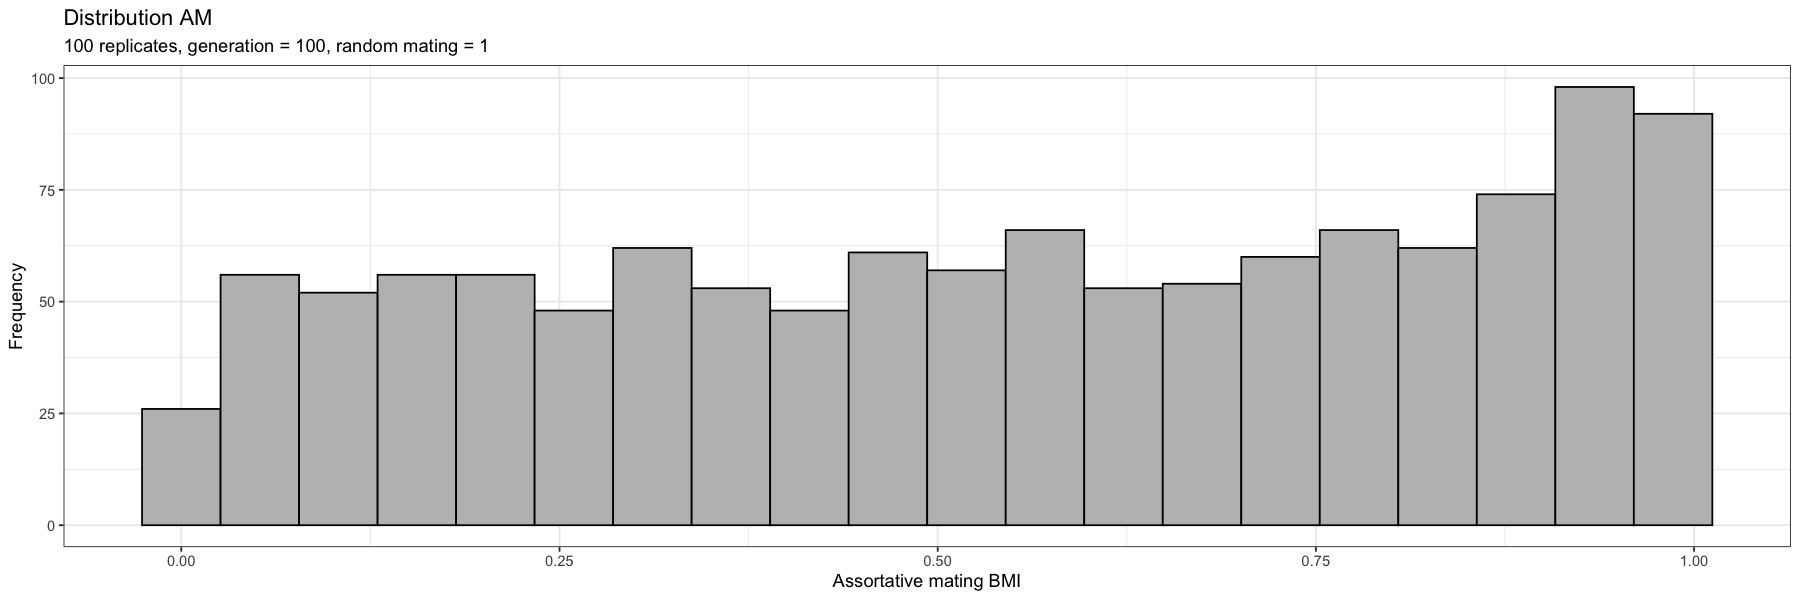

In [134]:
a = ggplot() + aes(pp)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "Assortative mating BMI", y = "Frequency", 
    title = "Distribution AM", 
    subtitle = "100 replicates, generation = 100, random mating = 1")
a

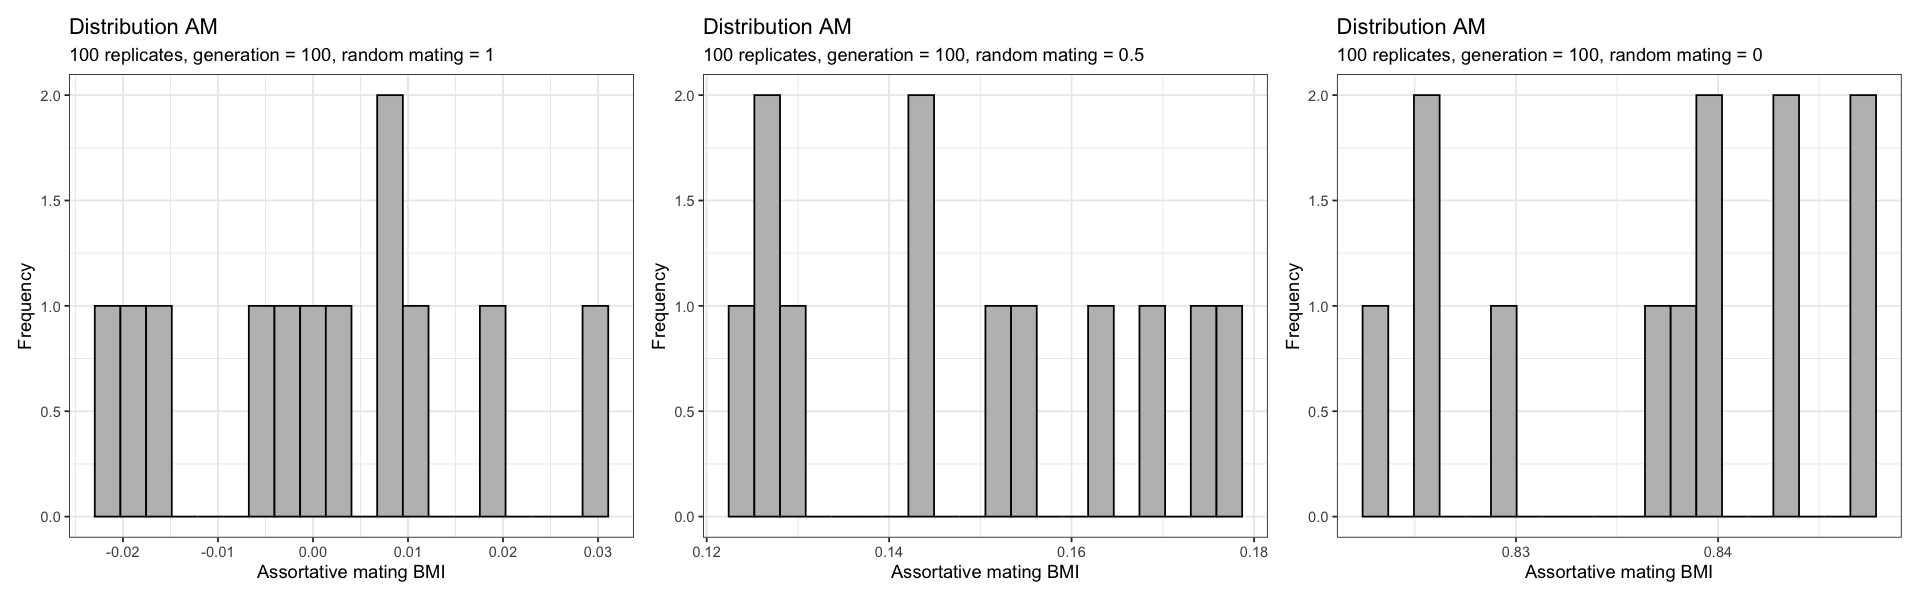

In [64]:
a = ggplot() + aes(rr[random_mating == 1, am_bmi])+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "Assortative mating BMI", y = "Frequency", 
    title = "Distribution AM", 
    subtitle = "100 replicates, generation = 100, random mating = 1")
b = ggplot() + aes(rr[random_mating == 0.5, am_bmi])+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "Assortative mating BMI", y = "Frequency", 
    title = "Distribution AM", 
    subtitle = "100 replicates, generation = 100, random mating = 0.5")
c = ggplot() + aes(rr[random_mating == 0, am_bmi])+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "Assortative mating BMI", y = "Frequency", 
    title = "Distribution AM", 
    subtitle = "100 replicates, generation = 100, random mating = 0")

options(repr.plot.width=16, repr.plot.height=5)
wrap_plots(a, b, c)

In [65]:
# compute p-values
getHWpvalues = function(data, idvar = "id", k = 1, nsample = NULL) {
    ids = unique(data[[idvar]])
    pvalues = NULL
    vars = names(data)[grepl("^snp[0-9]+$", names(data))] 
    for (i in ids) {
        temp = copy(data[id == i, ..vars])
        m = as.matrix(transpose(temp))
        # use k=1 for standard HW test
        LF = lfa(m, k)
        pvalues = c(pvalues, sHWE(m, LF, 4))
    }
    print(summary(pvalues))
    return(pvalues)
}


# Contrasting generation 0 and 100

In [66]:
pvalues0rm0 = getHWpvalues(df[generation == 0 &  random_mating == 0])
pvalues100rm0 = getHWpvalues(df[generation == 100 &  random_mating == 0])
pvalues0rm05 = getHWpvalues(df[generation == 0 &  random_mating == 0.5])
pvalues100rm05 = getHWpvalues(df[generation == 100 &  random_mating == 0.5])
pvalues0rm1 = getHWpvalues(df[generation == 0 &  random_mating == 1])
pvalues100rm1 = getHWpvalues(df[generation == 100 &  random_mating == 1])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2450  0.4938  0.4961  0.7350  1.0000 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1575  0.4175  0.4433  0.7200  0.9700 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2525  0.4950  0.5002  0.7531  1.0000 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1769  0.4325  0.4520  0.7150  0.9800 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2319  0.4825  0.4971  0.7606  1.0000 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1675  0.4062  0.4395  0.6975  0.9900 


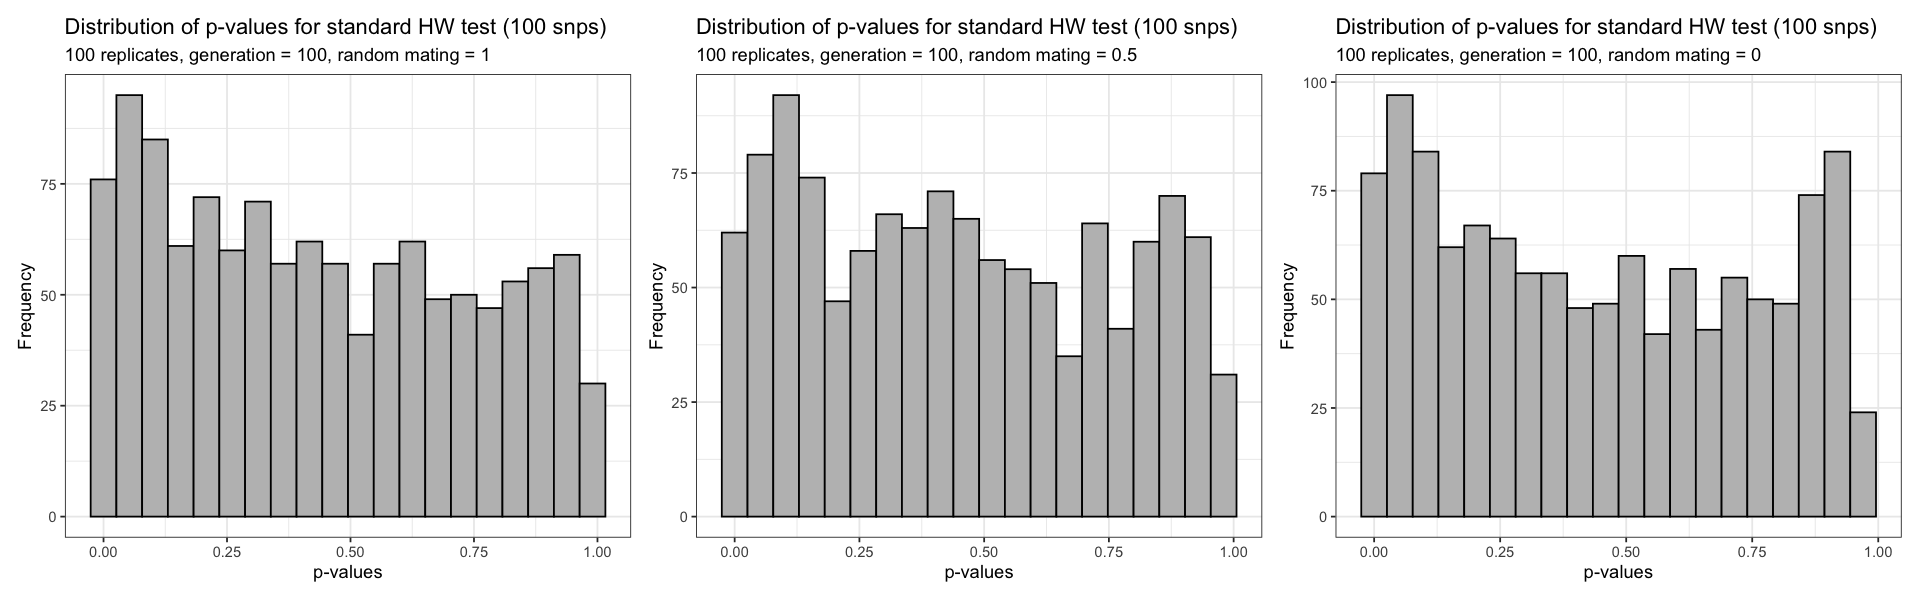

In [67]:
a = ggplot() + aes(pvalues100rm1)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)", 
    subtitle = "100 replicates, generation = 100, random mating = 1")
b = ggplot() + aes(pvalues100rm05)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)", 
    subtitle = "100 replicates, generation = 100, random mating = 0.5")
c = ggplot() + aes(pvalues100rm0)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)", 
    subtitle = "100 replicates, generation = 100, random mating = 0")

options(repr.plot.width=16, repr.plot.height=5)
wrap_plots(a, b, c)

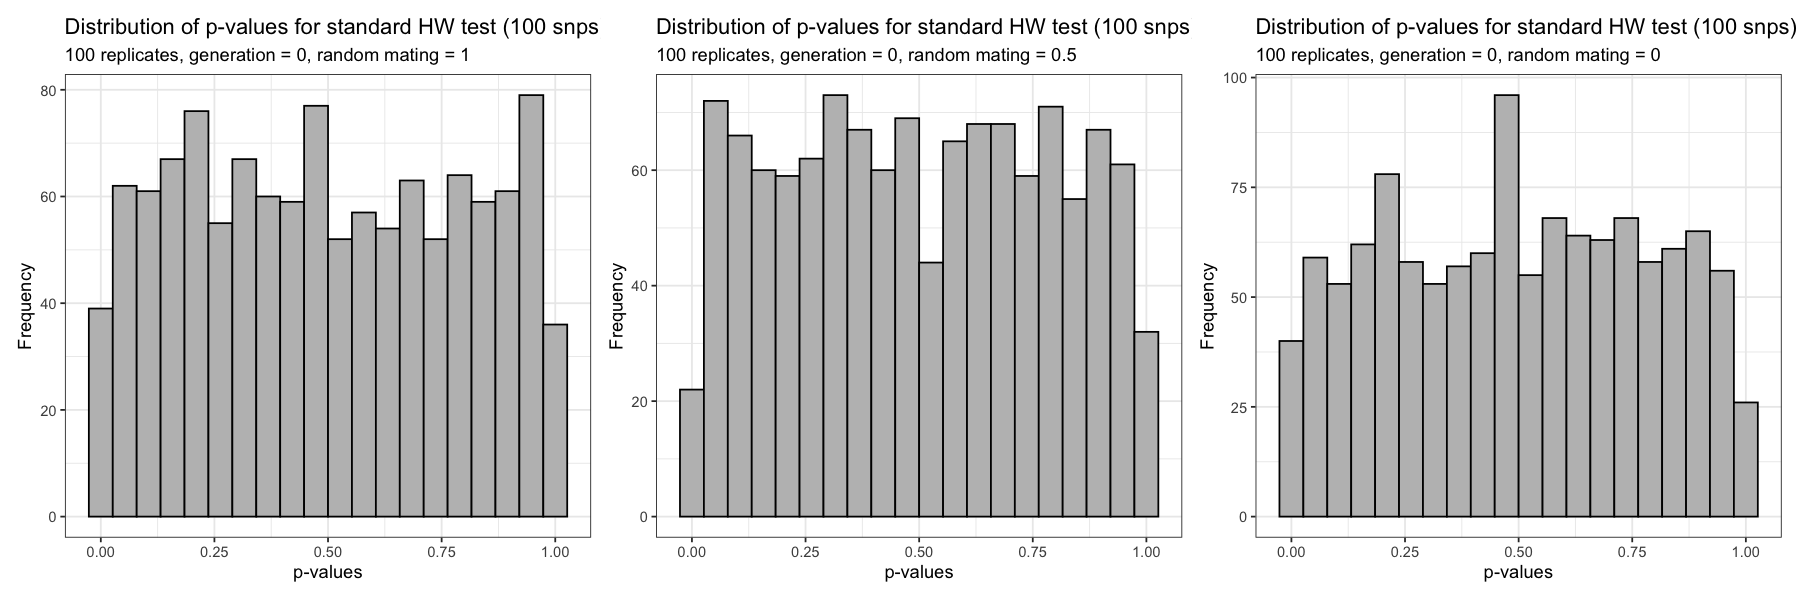

In [68]:
a = ggplot() + aes(pvalues0rm1)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)", 
    subtitle = "100 replicates, generation = 0, random mating = 1")
b = ggplot() + aes(pvalues0rm05)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)", 
    subtitle = "100 replicates, generation = 0, random mating = 0.5")
c = ggplot() + aes(pvalues0rm0)+ geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
    title = "Distribution of p-values for standard HW test (100 snps)", 
    subtitle = "100 replicates, generation = 0, random mating = 0")

options(repr.plot.width=15, repr.plot.height=5)
wrap_plots(a, b, c)